## Welcome to the next-to-last practical

This tutorial will show you how to get the computer to distinguish data between classes. There are many methods to classify data, but these can be summarised into (1) basic statistical methods; (2) machine learning; and (3) deep learning.

We will continue with the rooibos data. Given the small size of this dataset, this notebook will focus on developing basic statistical methods for classifying tea samples into fermented and nonfermented. We will also estimate the accuracy of classification methods.  When estimating accuracy, it is important also to determine how exact this estimate is--so we will also show how to compute the standard deviation of the accuracy estimate using the so-called jackknife. 

---

### Overview of the classification problem  in general

The following picture demonstrates the simple idea behind computational classification of objects. The general procedure is:
* Extract features from data;
* Pass the features into a model;
* The model outputs a determination of the sample's class.

<img src="pics/cat.png" width="700" height="300">

In this tutorial we are classifying tea samples, and the  features we will be using are the TPC, TEAC, and FRAP measurements obtained from chemical assays.

To make this work, the programmer must:
* Determine informative features to be used;
* Develop a model that can effectively make use of the features extracted;
* Evaluate the accuracy of the overall system


### Binary classification

Binary classification supposes that we are trying to distinguish between two classes, denoted as "null" and "positive". In this case when distinguishing there are two possible errors: false positive or false negative:
  * **[False positive](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where you receive a positive result for a test, when you should have received a negative (null) result. For example, it occurs when a cancer screening test comes back positive, but you don’t have the disease.
  * **[False negative](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where a negative (null) test result is wrong. For example, in the Justice System, a false negative occurs when a guilty suspect is found “not guilty” and allowed to walk free.
  
Based on these definitions, we may define:

   * _False positive rate_: What proportion of positive identifications was actually correct?
   * _False negative rate_: What proportion of actual positives was identified correctly?

These two work against each other: decreasing the false positive rate tends to increase the false negative rate.


* False positive rate is related to [specificity  and precision](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)
* False negative rate is related to [recall and sensitivity](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)

### Threshold

Usually binary classification is based on a single quantity calculated from the features of the data sample. If this quantity exceeds a threshold (which is set by the programmer) then the sample is judged to be in one class, and if not the sample is put in the other class.

The following figure shows 30 predictions made by an email classification model. Those to the right of the classification _threshold_ are classified as "spam", while those to the left are classified as "not spam."

<img src="pics/preVSrec.svg" width="700" height="200">

where the results can be summaried as follows:

<img src="pics/table.png" width="300" height="150">


From these we may calculate:

* _Precision_ (specificity) measures the percentage of **emails flagged as spam** that were correctly classified—that is, the percentage of dots to the right of the threshold line that are green in Figure above
<img src="pics/pre.png" width="350" height="150">
* _Recall_ (sensitivity)  measures the percentage of **actual spam emails** that were correctly classified—that is, the percentage of green dots that are to the right of the threshold line in Figure 1:
<img src="pics/rec.png" width="330" height="160">
* _Accuracy_ gives the overall percentage of correct classifications, and can be calculated  as follows: <br><br>
<img src="pics/acc.png" width="550" height="270">

Different thresholds will give different values for these three measures. 

---

[**Exercise 1:**](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall) Consider a classification model that separates email into two categories: "spam" or "not spam." If you raise the classification threshold, what will happen to precision? What about recall?


---

#### Method 1: Receiver operating characteristic [(ROC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) curves

Receiver operating characteristic (ROC) curves are used to determine thresholds based on the trade-off between false positive error and false negative error. The ROC curve tells you what false positive rate to expect for a given false negative rate.

Our example will use code the python packages matplotlib, numpy, and sklearn.  In addition, we will make use of some pre-written programs that are located in the `source` directory. We begin by importing these packages.



In [1]:
## Python packages 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

## Prewritten codes in 'source' directory:

# The following code draws the ROC curves
from source.roc import draw_roc 

# The following code computes "Mahalanobis distance" 
# (https://en.wikipedia.org/wiki/Mahalanobis_distance), which can be used as a criterion
from source.baseline_acc import get_accuracy_base 

# The following code implements jackknife (to be discussed below) 
from source.calculate_jack import jack_SD 

## Recover data from files
%store -r df_nf
%store -r df_fer
%store -r df

print("Shape of data frame (rows, columns) is: ", df.shape) 

Shape of data frame (rows, columns) is:  (98, 8)


First let's look at the imported data

In [2]:
print(df.head(2))

   type    TPC_MEOH    TEAC_MEOH    FRAP_MEOH  TPC_H2O  TEAC_H2O  FRAP_H2O cut
0     0  275.767474  2821.888864  1180.778887   314.33   2588.61    584.61  FC
1     0  253.494375  2355.706326   647.096605   331.41   2818.87    589.91  LL


---

Now let's create arrays for the inputs and outputs.

In [3]:
feat_H2O = ['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O'] # define the input (features) for H20
feat_MEOH = ['TPC_MEOH', 'TEAC_MEOH',  'FRAP_MEOH'] # define the input (features) for MeOH

y = df[['type']] # define the output (target)

We consider the case where we are trying to use individual features to distinguish between fermented and nonfermented.  Since we have three different features, for each feature we can set a classification threshold.  The question is:  of these three features, which will give better classification results? We may use the ROC curves associated with each feature to determine this.

Let's call the `draw_roc` function to draw the three ROC curves using the arrays we defined above

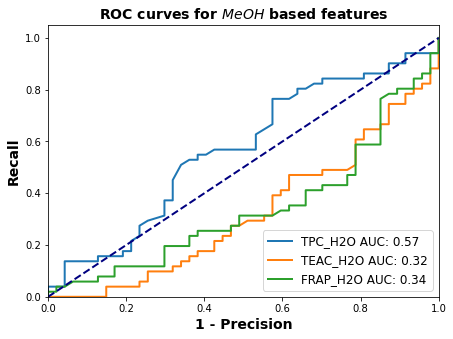

In [4]:
# ROC curves
di_h2o =[True, True, True] # if one of the features direction is below the 45 degrees, then we make it False
draw_roc (df, di_h2o, feat_H2O, y)


In many references, the $x$ and $y$ axes are labeled as "False positive" and "True positive", respectively. Each line in the above graph shows the true positive and false positive rates for classifiers based on a threshold applied to a single feature.  The $x$ and $y$ values depend on the threshold that is set (the thresholds themselves not shown in the graph--only the rates are shown).  For example, if we use the `TEAC-H2O` features and set the threshold  so that the false positive rate is 0.5 (i.e. the specificity is 1- 0.5 = 0.5), then the true positive rate (recall) is about 0.3. 

The dotted line corresponds to random guessing:  if you simply make random guesses, then the true and false positive rates will be equal.  A good classifier will have a large true positive rate and small false positive rate. In other words, you want your ROC cuve to lie *above* the dotted line.  However, we can see that the TEAC_H2O and FRAP_H2O lines are *below* the dotted line.  This means that these classifiers are *worse* than random guessing.  How to solve this problem? Easy--instead of saying above the the threshold is 'positive', assign it to 'negative' (and similarly with below the threshold).  We can do this in the code by specifying the option `False` in line 2 of the above code for TEAC_H2O and FRAP_H2O. 

---
**Exercise 2:** Copy and change the above code so that all ROC curves lie above the dotted line.
<br>


In [5]:
#  ___ code here ____



---
**Exercise 3:** Make another graph for the three features based on MeOH. Make sure that all curves are above the dotted line.
<br>


In [6]:
#  ___ code here ____



The ROC curve does not actually tell you which threshold to use--it simply tells you what precision/recall tradeoffs are possible.  The user will have to decide which tradeoff is most suitable for his situation, and set the threshold accordingly. 

ROC curves are especially useful if you want to compare different classifiers. Classifiers with higher ROC curves are better than classifiers with lower curves.


---
**Exercise 3:** Of the six features shown above, which gives the best classifiers?

---

### Statistical Baseline


Simpler is better. Before trying more advanced ML classification techniques, it is always good to use a simple method to set a baseline for comparison.  The simplest classification methods are based on elementary statistics.

One standard statistical classification method uses the so-called *Mahalanobis distance*. Given a probability distribution, the Mahalanobis distance of a data point to that distribution measures the "likelihood" that that data point belongs to the distribution. So if we have two or more distributions and want to assign a data point to one of them, we choose the distribution that gives the smallest [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). One big advantage of Mahalanobis distance is that it can be used to classify data based multiple features (unlike ROC curves, which only work for single-feature classification).

This classification is easy to program in Python. We will demonstrate on our classification of rooibos into fermented and nonfermented. Recall that our data is contained in the dataframe `df`, and the `type` column indicates nonfermented (0) or fermented (1).  We call this our `target output`, and record it in the variable `y`.

In [10]:
y = df[['type']]

Then let us list the feature groups that we will use for classification. Each feature group will give us a different classifier.

In [11]:
features = [ ['TPC_H2O'], ['TEAC_H2O'],  ['FRAP_H2O'], ['TPC_H2O', 'TEAC_H2O']]

At this point, we need to split the data between training data and testing data. The training data is used to  estimate the distribution parameters of fermented and nonfermented. Then, the testing data is used to evaluate the performance of the resulting classifiers.

There is no set rule for choosing the split between training and testing, although generally most of the data is used for training. So we try some different splits. Later, we will use jackknife to see which split gives the most reliable estimator.

In [12]:
splits = [0.4, 0.2]# Each number gives the proportion of testing data for a particular split

It is convenient to store the results in a *dictionary*.  A dictionary is a Python data structure consisting of key-value pairs. Just like in a regular dictionary, stored values are referenced by keyword, instead of using an index as in lists or arrays. For more information on dictionaries, see: https://www.geeksforgeeks.org/python-nested-dictionary/

First we define an empty dictionary to hold our results.

In [13]:
base_dict = {} 
# https://www.geeksforgeeks.org/python-nested-dictionary/  (for more exploration around dictionaries) 

The following code trains and evaluates 8 classifiers (4 feature sets with 2 splits per feature set).  The code produces the following outputs for each classifier:

* `tot_acc`    : a variable that stores the total accuracy
* `jack_train` : a list that tores different accuracies after deleting samples from the training 
* `jack_test`  : a list that stores different accuracies after deleting samples from the testing

we are calculating multiple accuracies for purpose of calculating the standard deviation later on

In [14]:
for s in splits:
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= s, random_state=1, stratify = y, shuffle = True)
    
    for f in features:
        xtr =  X_train[f]
        xte =  X_test[f]
        results = get_accuracy_base (xtr, y_train, xte, y_test, len(f)) # to get the accuarcies for the baseline
        
        key = str(s)+","+str(f)
        
        base_dict[key] = {}
        base_dict[key]['tot_acc'] = results[0]
        base_dict[key]['jack_train'] = results[1]
        base_dict[key]['jack_test'] = results[2]
        # print(base_dict)
        # print()

In [12]:
%store base_dict 
# we will use this Dictionary in the next notebook

Stored 'base_dict' (dict)


playing around with dictionaries 

In [13]:
print(base_dict.keys())
key = list(base_dict.keys())[0]
print( base_dict[key].keys() )

dict_keys(["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']", "0.2,['TPC_H2O']", "0.2,['TEAC_H2O']", "0.2,['FRAP_H2O']", "0.2,['TPC_H2O', 'TEAC_H2O']"])
dict_keys(['tot_acc', 'jack_train', 'jack_test'])


now let us graph the accuracy with the SD (should I turn it into a function)

In [14]:
acc_arr = [] 
sd_arr = [] 


for key in base_dict.keys():
    
    print( str(key)+": "+str(base_dict[key][ 'tot_acc' ] ))
    acc_arr.append(base_dict[key][ 'tot_acc' ]) # append total accuarcy to an array
    sd_train = jack_SD( np.zeros( len(base_dict[key][ 'jack_train' ]) ), base_dict[key][ 'jack_train' ])[0]
    sd_test = jack_SD( np.zeros( len(base_dict[key][ 'jack_test' ]) ), base_dict[key][ 'jack_test' ])[0]
    sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
    sd_arr.append(sd) # append sd_arr to an array

    print(sd)
    print()
    


0.4,['TPC_H2O']: 0.55
0.08996396844211696

0.4,['TEAC_H2O']: 0.675
0.13291317134775255

0.4,['FRAP_H2O']: 0.75
0.3032381727198833

0.4,['TPC_H2O', 'TEAC_H2O']: 0.85
0.05717718748968661

0.2,['TPC_H2O']: 0.5
0.26668904971981533

0.2,['TEAC_H2O']: 0.7
0.10513149660756924

0.2,['FRAP_H2O']: 0.7
0.2379385671900674

0.2,['TPC_H2O', 'TEAC_H2O']: 0.8
0.0917662935482246



<ErrorbarContainer object of 3 artists>

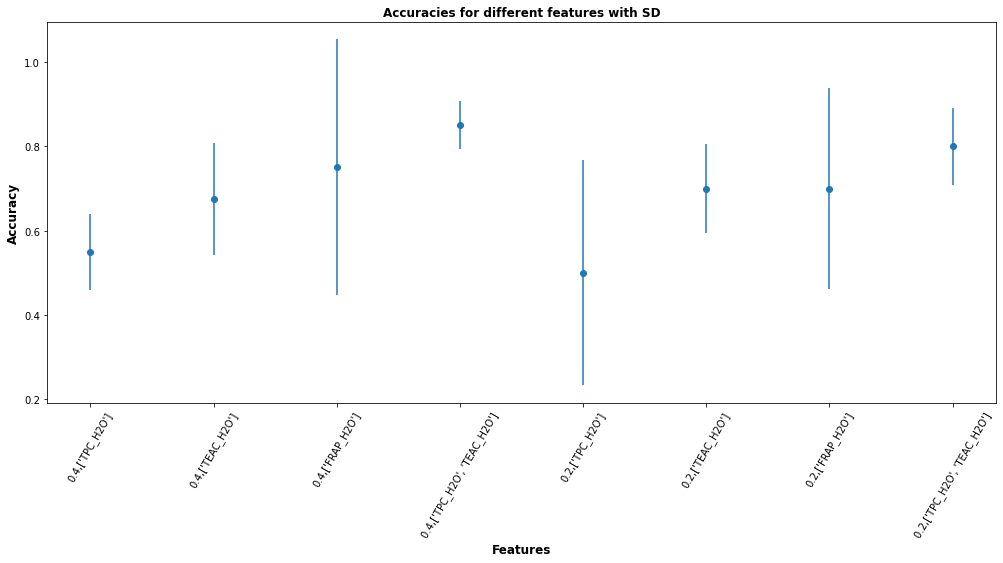

In [15]:
plt.figure(figsize=(17 , 7))
plt.title( "Accuracies for different features with SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.xticks(rotation = 60) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("Accuracy", fontweight ='bold', fontsize =12)
plt.errorbar( list(base_dict.keys()), acc_arr, sd_arr, fmt='o')


### Now try to add more features, and try with methanol

In [16]:
# ----- code here ------------

### Now try to mix both methanol and water extracts

In [17]:
# ----- code here ------------

### now draw a conclusion
- hint: usually it be the highest accuracy with the lowest SD will be the best method